## TODO
1. Plot net load curve
1. Source for emissions
1. Add generation mix for CO2 cap
1. Plot opt capacity for weather years (change Co2 cap?)
1. Fix hydro CF

## Task A: optimize a region

In [77]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import pypsa 
import warnings
import os
import sys
import contextlib
warnings.filterwarnings("ignore")

# Function to reduce console print of optimizer
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Import datasets for region and year of interest
country = "FIN"
year = 2015

demand_all = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True )
demand_all.index = demand_all.index.tz_localize(None)
demand = demand_all[country].loc[demand_all.index.year == year]

onshore_all = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore_all.index = onshore_all.index.tz_localize(None)
onshore_all = onshore_all[~((onshore_all.index.month == 2) & (onshore_all.index.day == 29))] # Remove leap day
onshore_2015 = onshore_all[country].loc[onshore_all.index.year == year]

solar_all = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar_all.index = solar_all.index.tz_localize(None)
solar_all = solar_all[~((solar_all.index.month == 2) & (solar_all.index.day == 29))] # Remove leap day
solar_2015 = solar_all[country].loc[solar_all.index.year == year]

heat_all = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat_all.index = heat_all.index.tz_localize(None)
heat = heat_all[country].loc[solar_2015.index.year == year]

# Import hydro data
hydro_all = pd.read_csv("hydro.csv", sep=";", index_col=0, parse_dates=True)
hydro_all = hydro_all["Hydro power production - real time data"]
hydro_all.index = hydro_all.index.tz_localize(None)
hydro_all = hydro_all.resample("H").mean()/3100 # Estimate capacity factor based on current installed capacity of 3.1 GW
hydro_all = hydro_all.fillna(method="ffill") # Fill NaN with previous value
hydro_all = hydro_all[~((hydro_all.index.month == 2) & (hydro_all.index.day == 29))] # Remove leap day
hydro_2015 = hydro_all.loc[hydro_all.index.year == year]

# Extend hydro data to cover the entire period of interest
start_target = pd.Timestamp('1979-01-01 00:00')
end_target = pd.Timestamp('2017-12-31 23:00')
num_repeats = 11
hydro_extended = pd.concat([hydro_all.copy() for _ in range(num_repeats)], axis=0)
hydro_extended.index = pd.date_range(start=start_target, periods=len(hydro_extended), freq='H')

# Remove leap day
hydro_extended = hydro_extended[~((hydro_extended.index.month == 2) & (hydro_extended.index.day == 29))] # Remove leap day
# Keep only data within the target range
hydro_extended = hydro_extended[(hydro_extended.index >= start_target) & (hydro_extended.index <= end_target)]

# Get snapshots for the year of interest
snapshots = demand.index


In [78]:
# Annuity function for converging capital costs to annualized costs
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

# Import costs from PyPSA technology data
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert cost units to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

# Set OCGT cost and emissions to gas values
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Set OCGT cost and emissions to gas values
costs.at["biomass CHP", "CO2 intensity"] = costs.at["solid biomass", "CO2 intensity"]
costs.at["biomass CHP", "fuel"] = costs.at["solid biomass", "fuel"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [79]:
# Create a PyPSA network
network = pypsa.Network()
network.set_snapshots(snapshots.values)

# Add electricity bus
network.add("Bus", "FIN_el")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    "biomass CHP",
    "coal",
    "hydro",

]

colors = ["dodgerblue", "gold", "brown", "blue", "green", "orange", "red", "purple"]

# Add carriers to the network with CO2 emissions and colors
for i, carrier in enumerate(carriers):
    network.add("Carrier", carrier, co2_emissions=costs.at[carrier, "CO2 intensity"], color=colors[i])

# Define capacity factors for each carrier
CF = pd.DataFrame(1, index=snapshots, columns=carriers)
CF = CF.assign(onwind=onshore_2015.values, solar=solar_2015.values, hydro=hydro_2015.values )

# Add electricity load
network.add("Load", "el_load", bus="FIN_el", p_set=demand.values)

# Add generators
for carrier in carriers:
        network.add("Generator", carrier, bus="FIN_el", p_nom_extendable=True, 
                    p_max_pu      = CF[carrier].values,
                    marginal_cost = costs.at[carrier, "marginal_cost"], 
                    efficiency    = costs.at[carrier, "efficiency"], 
                    capital_cost  = costs.at[carrier, "capital_cost"], 
                    carrier       = carrier
        )

# Limit the capacity of hydro
network.generators.loc["hydro", "p_nom_max"] = 3100 # MW


# Optimize with reduced output
# Suppress the solver output by using the context manager
with suppress_stdout():
    network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

Index(['FIN_el'], dtype='object', name='Bus')
Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.54it/s]
INFO:linopy.io: Writing time: 0.7s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file C:\Users\sofie\AppData\Local\Temp\linopy-problem-8t7oqrfh.lp
INFO:gurobipy:Reading time = 0.20 seconds
INFO:gurobipy:obj: 131408 rows, 61327 columns, 241259 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131408 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to 

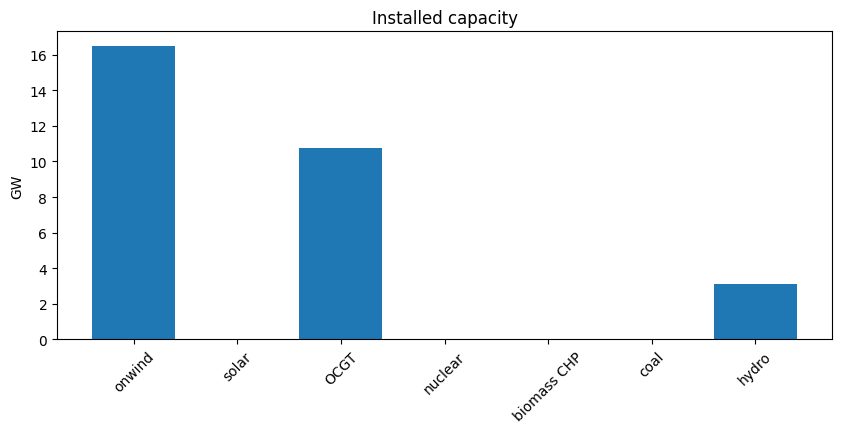

In [80]:
# Extract results
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

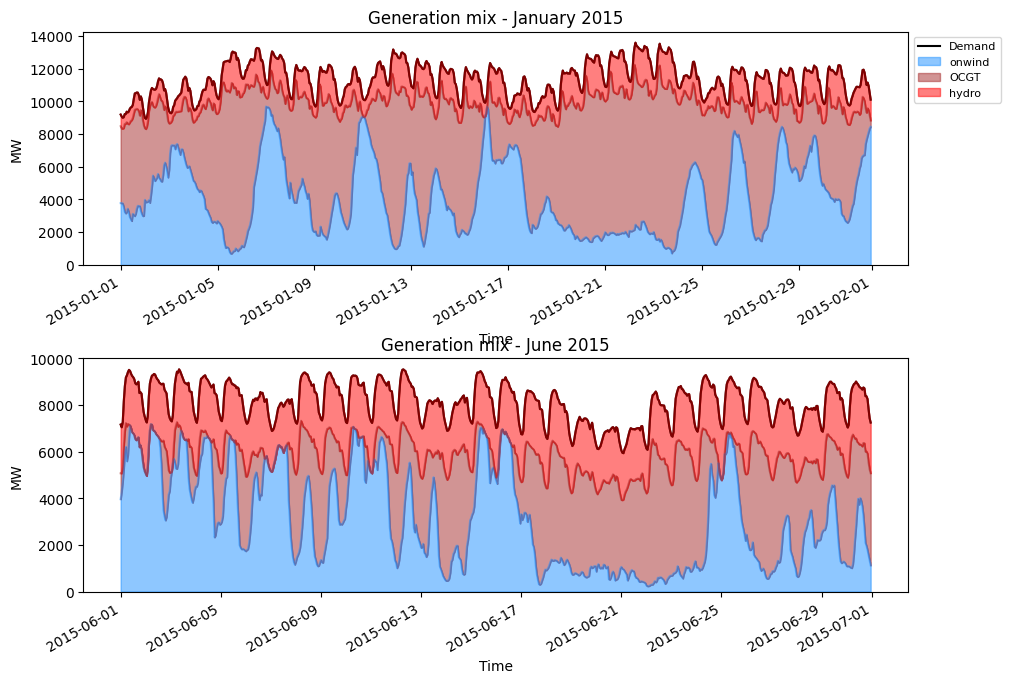

In [81]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-31"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-30"

demand_jan = demand.loc[start_date_jan:end_date_jan]
generator_jan = gen_prod.loc[start_date_jan:end_date_jan,  (gen_prod != 0).any(axis=0)]

demand_jun = demand.loc[start_date_jun:end_date_jun, ]
generator_jun = gen_prod.loc[start_date_jun:end_date_jun, (gen_prod != 0).any(axis=0)]


fig, ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January 2015")
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Time")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June 2015")
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Time")

plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()

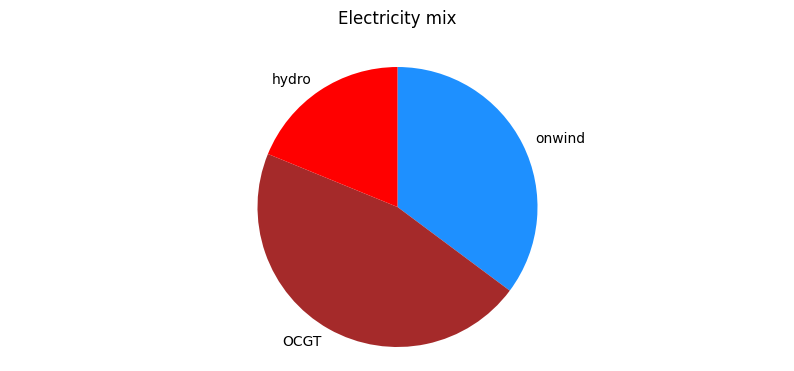

In [82]:
# Plot electricity mix
energy_production = network.generators_t.p
energy_sum = energy_production.sum(axis=0)
energy_sum = energy_sum[energy_sum != 0]

fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
plt.pie(energy_sum.values, labels=energy_sum.index, colors=energy_sum.index.map(network.carriers.color), startangle=90, counterclock=False);
plt.axis('equal')
plt.title('Electricity mix', y=1.07)
plt.show()

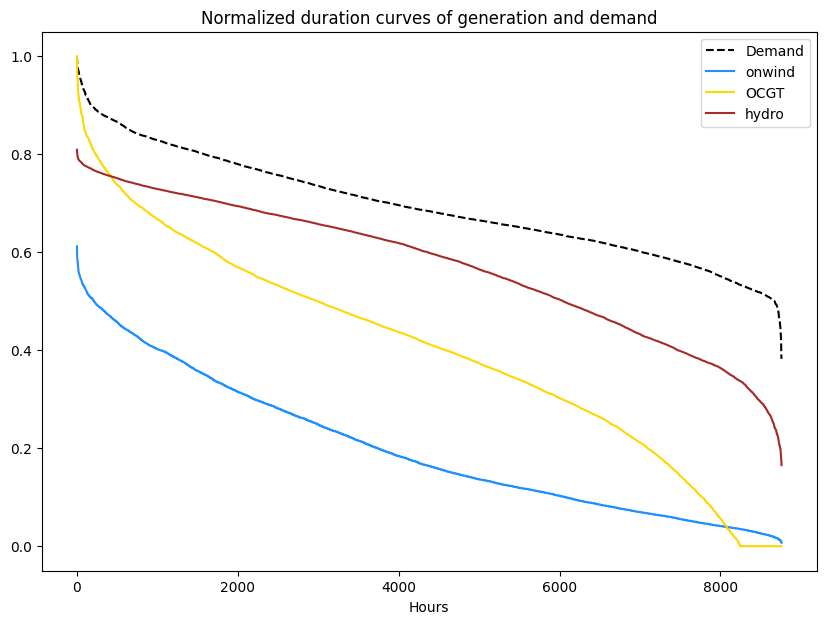

In [83]:
# Plot duration curves of generation and demand
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot((demand/max(demand)).sort_values(ascending=False).reset_index(drop=True), label="Demand", color="black", linestyle="--")

for i, col in enumerate(energy_sum.index):
    ax.plot((energy_production[col]/gen_cap[col]).sort_values(ascending=False).reset_index(drop=True), label=col, color=colors[i])

plt.legend()
plt.title("Normalized duration curves of generation and demand")
plt.xlabel("Hours")
plt.show()

#### Add net load curve

## B: CO2 limits

In [84]:
# Add a CO2 limit constraint, for now a dummy value
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=119E5, #11.9MtCO2
    type="primary_energy",
)

Index(['CO2Limit'], dtype='object')

In [85]:
# Prepare for sensitivity analysis
sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}
co2_price = {}

# Compute the total system cost (capital + operational) for the current network
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

# Define the CO2 limits for sensitivity analysis and run the optimization for each limit
co2Limits = [30, 20, 11.9, 6.23, 3, 1, 0.5]
for co2 in co2Limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6 # MtCO2/a
    
    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

    
    sensitivity_cost[co2] = system_cost(network)
    sensitivity_capacity[co2] = network.generators.p_nom_opt.copy()
    sensitivity_production[co2] = network.generators_t.p.sum(axis=0)
    co2_price[co2] = -network.global_constraints.mu['CO2Limit']

Index(['FIN_el'], dtype='object', name='Bus')
Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 18.83it/s]
INFO:linopy.io: Writing time: 0.75s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file C:\Users\sofie\AppData\Local\Temp\linopy-problem-khx3bq90.lp
INFO:gurobipy:Reading time = 0.24 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267539 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to

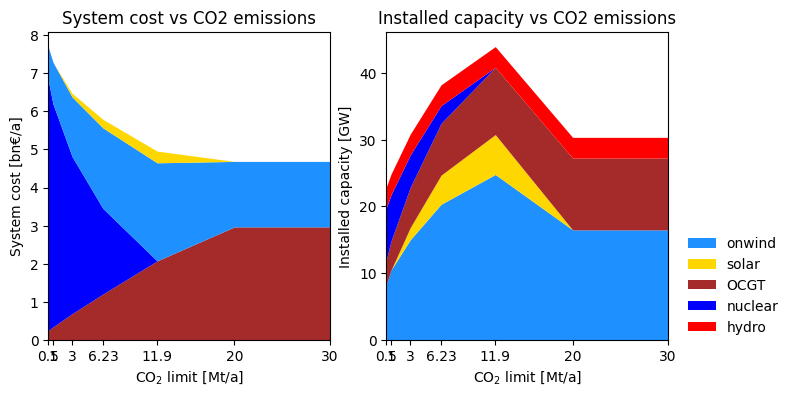

In [86]:
sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T.div(1e3)  # GW
sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a

# Include only technologies that are used in the network
sens_cost = sens_cost.loc[:, sens_cost.sum() != 0]
sens_cap = sens_cap.loc[:, sens_cap.sum() != 0]

fix, ax = plt.subplots(1,2, figsize=(10, 20))
# Plot system cost vs CO2 emissions
sens_cost.plot.area(
    ax = ax[0],
    stacked=True, linewidth=0,
    color=sens_cost.columns.map(network.carriers.color),
    figsize=(4, 4), xlim=(min(co2Limits), max(co2Limits)),
    xlabel=r"CO$_2$ limit [Mt/a]",
    ylabel="System cost [bn€/a]",
    title="System cost vs CO2 emissions",
)
ax[0].set_xticks(co2Limits, co2Limits)
ax[0].get_legend().remove()

sens_cap.plot.area(ax = ax[1], 
                  stacked = True, linewidth=0,
                  color = sens_cap.columns.map(network.carriers.color),
                  figsize=(8, 4), xlim=(min(co2Limits), max(co2Limits)),
                    xlabel=r"CO$_2$ limit [Mt/a]",
                    ylabel="Installed capacity [GW]",
                    title="Installed capacity vs CO2 emissions",
)
ax[1].set_xticks(co2Limits, co2Limits)
ax[1].legend(frameon=False, loc=(1.05, 0))
plt.show()

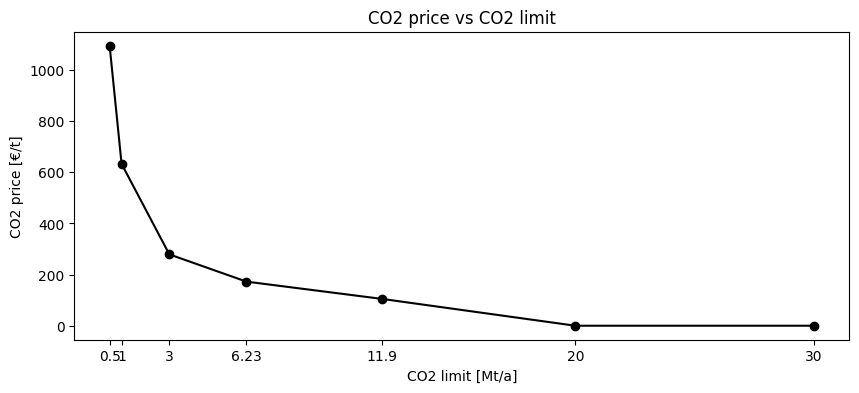

In [87]:
# Plot CO2 price vs CO2 limit
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(co2Limits, co2_price.values(), marker="o", color="black")
ax.set_xticks(co2Limits, co2Limits)
ax.set_xlabel("CO2 limit [Mt/a]")
ax.set_ylabel("CO2 price [€/t]")
ax.set_title("CO2 price vs CO2 limit")
plt.show()

## C: new weather

In [ ]:
weather_years = np.arange(1979, 2018)

sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}

# Reset CO2 limit
network.global_constraints.loc["CO2Limit", "constant"] = 3 * 1e6 # MtCO2/a

for year in weather_years:
    onshore = onshore_all[country].loc[onshore_all.index.year == year]
    solar = solar_all[country].loc[solar_all.index.year == year]
    hydro = hydro_extended.loc[hydro_extended.index.year == year][:8760]

    # Update model
    network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values, solar=solar.values, hydro=hydro.values)

    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})


    sensitivity_cost[year] = system_cost(network)
    sensitivity_capacity[year] = network.generators.p_nom_opt.copy()
    sensitivity_production[year] = network.generators_t.p.copy()

sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T.div(1e3) # GW

Index(['FIN_el'], dtype='object', name='Bus')
Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s]
INFO:linopy.io: Writing time: 0.8s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file C:\Users\sofie\AppData\Local\Temp\linopy-problem-pn0qytqd.lp
INFO:gurobipy:Reading time = 0.24 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267571 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 7.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to 

In [ ]:
# # Plot duration curves for each technology and year
# fig , ax = plt.subplots(4, 2, figsize=(10,7), sharex=True, sharey=True)

# for i, tech in enumerate(sens_cap.columns):
#     for year in weather_years:
#         ax[i//2, i%2].plot((sensitivity_production[year][tech]/sens_cap.loc[year, tech]).sort_values(ascending=False).reset_index(drop=True),
#                             label=year)
#         ax[i//2, i%2].set_title(tech)
#         ax[i//2, i%2].set_xlabel("Hours")

# plt.legend(loc="best")
# plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
# plt.show()

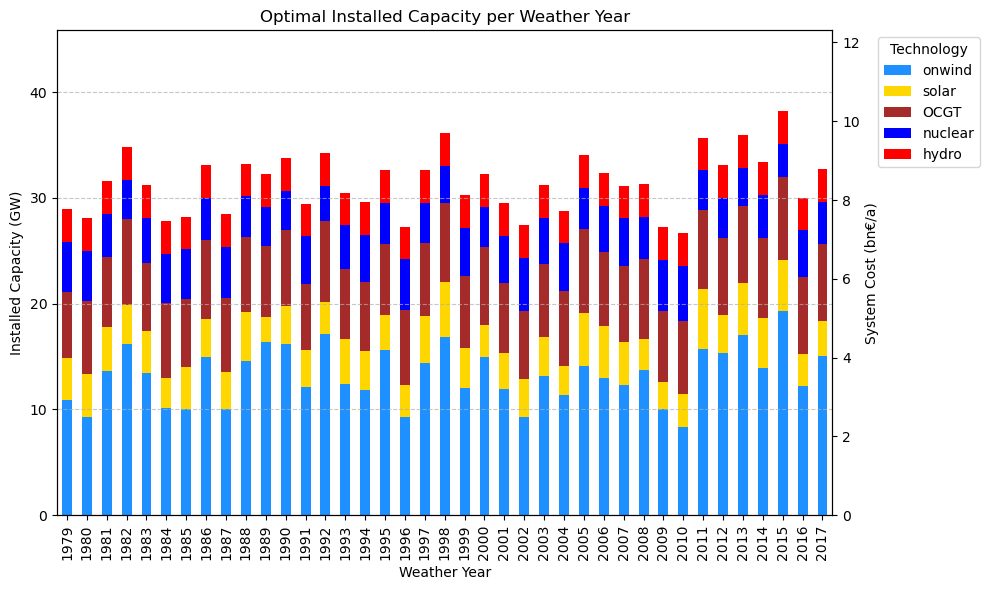

In [ ]:
# Capacity plot MANGLER SYSTEM COST!
yearly_cost = sens_cost.sum(axis=1)

color=sens_cost.columns.map(network.carriers.color)
# Clean sens_cap: remove columns with very small capacity
sens_cap_clean = sens_cap.loc[:, sens_cap.max() > 0.1]

# Only plot the carriers present in sens_cap
present_carriers = sens_cap_clean.columns

# Map the correct colors from network.carriers.color
plot_colors = present_carriers.map(network.carriers.color)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart with twin axes
ax1 = sens_cap_clean.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=plot_colors,
    ax=ax1
)
ax1.set_title("Optimal Installed Capacity per Weather Year")
ax1.set_xlabel("Weather Year")
ax1.set_ylabel("Installed Capacity (GW)")
ax1.set_ylim(0, sens_cap_clean.sum(axis=1).max() * 1.2)  # Adjust y-axis limits as needed
ax1.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis="y", linestyle="--", alpha=0.7)

ax2 = ax1.twinx()
yearly_cost.plot( kind="line", color="black", ax=ax2, linewidth=5, label="System Cost (bn€/a)")
ax2.set_ylabel("System Cost (bn€/a)")
ax2.set_ylim(0, yearly_cost.max() * 1.7)  


fig.tight_layout()
fig.show()

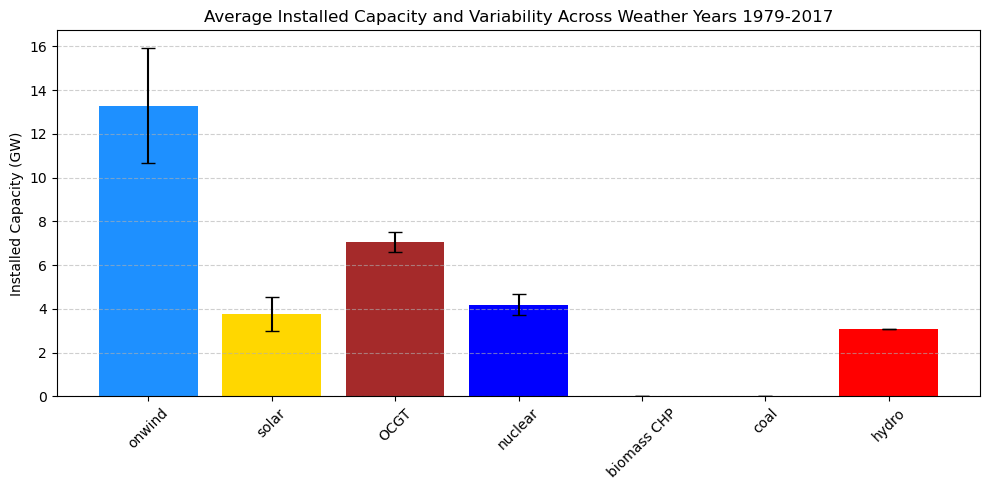

In [ ]:
#Variability plot

# Calculate average and standard deviation
mean_cap = sens_cap.mean(axis=0)
std_cap = sens_cap.std(axis=0)

plt.figure(figsize=(10, 5))
plt.bar(mean_cap.index, mean_cap.values, 
        yerr=[std_cap.values, std_cap.values], 
        capsize=5, 
        color=mean_cap.index.map(network.carriers.color))
plt.ylabel("Installed Capacity (GW)")
plt.title("Average Installed Capacity and Variability Across Weather Years 1979-2017")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## D: Add storage

In [ ]:
# Reset basis year to 2015
year = 2015
network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6 # MtCO2/a

onshore = onshore_all[country].loc[onshore_all.index.year == year]
solar = solar_all[country].loc[solar_all.index.year == year]
hydro = hydro_extended.loc[hydro_extended.index.year == year]

# Update model
network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values, solar=solar.values, hydro=hydro.values)

# Add storage bus
network.add("Carrier", "battery storage", co2_emissions=0, color="purple")
carriers.append("battery storage")

network.add(
    "StorageUnit",
    "battery storage",
    bus="FIN_el",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
    overwrite=True,
)


# Optimize with reduced output
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

Index(['FIN_el'], dtype='object', name='Bus')
Index(['battery'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 34.79it/s]
INFO:linopy.io: Writing time: 0.78s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-rz0fezms.lp
INFO:gurobipy:Reading time = 0.31 seconds
INFO:gurobipy:obj: 219011 rows, 96369 columns, 451501 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96369 primals, 219011 duals
Objective: 9.76e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-u

<Axes: xlabel='snapshot'>

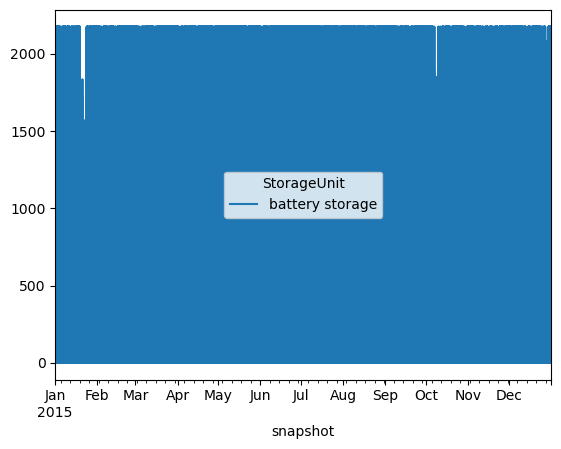

In [ ]:
# plot battery storage
network.storage_units_t.state_of_charge.plot(figsize=(10, 4), color="purple")
plt.title("Battery Storage State of Charge")
plt.xlabel("Time")
plt.ylabel("State of Charge (MWh)")


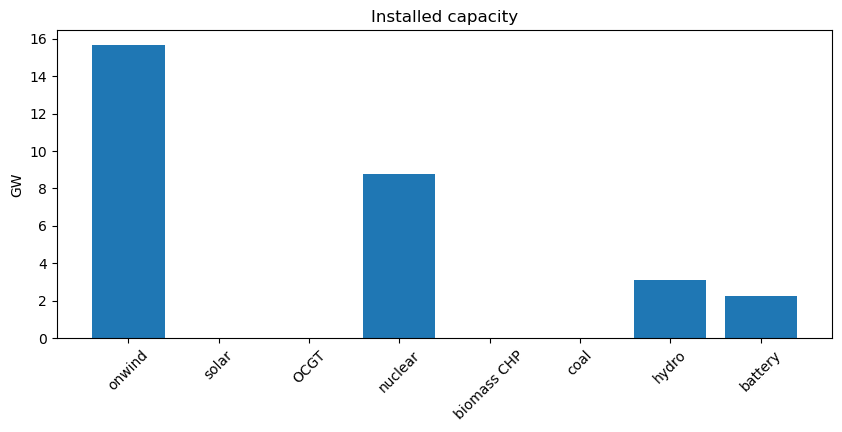

In [ ]:
# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.links.p_nom_opt], axis=0)
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

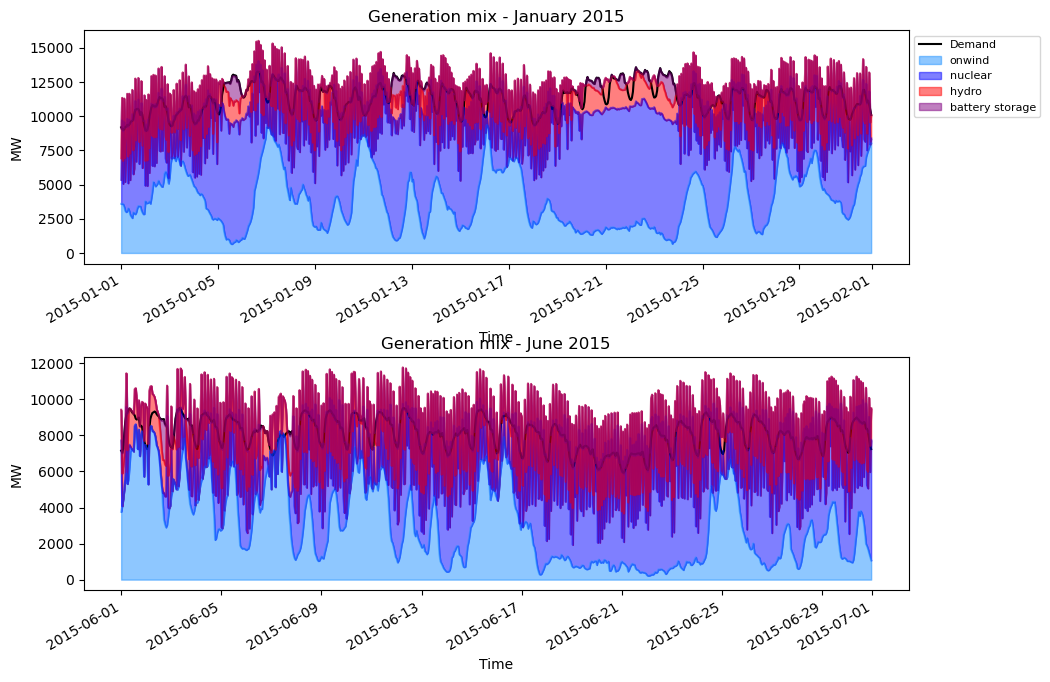

In [ ]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-31"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-30"

demand_jan = demand.loc[start_date_jan:end_date_jan]
generator_jan = total_gen_prod.loc[start_date_jan:end_date_jan,  (total_gen_prod != 0).any(axis=0)]

demand_jun = demand.loc[start_date_jun:end_date_jun, ]
generator_jun = total_gen_prod.loc[start_date_jun:end_date_jun, (total_gen_prod != 0).any(axis=0)]


fig, ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January 2015")
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Time")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June 2015")
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Time")

plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()

## E: Determine CO2 price for CO2 target

In [ ]:
# Set CO2 limit to 0 and optimize again
network.global_constraints.loc["CO2Limit", "constant"] = 6 * 1E6 # MtCO2/a

# Optimize model
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

# Extract CO2 price
co2_price = -network.global_constraints.mu['CO2Limit']

Index(['FIN_el'], dtype='object', name='Bus')
Index(['battery'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 104.29it/s]
INFO:linopy.io: Writing time: 0.6s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-bd76l33e.lp
INFO:gurobipy:Reading time = 0.22 seconds
INFO:gurobipy:obj: 219011 rows, 96369 columns, 451501 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96369 primals, 219011 duals
Objective: 6.58e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-u

CO2 price: 166.564813758937 €/tCO2


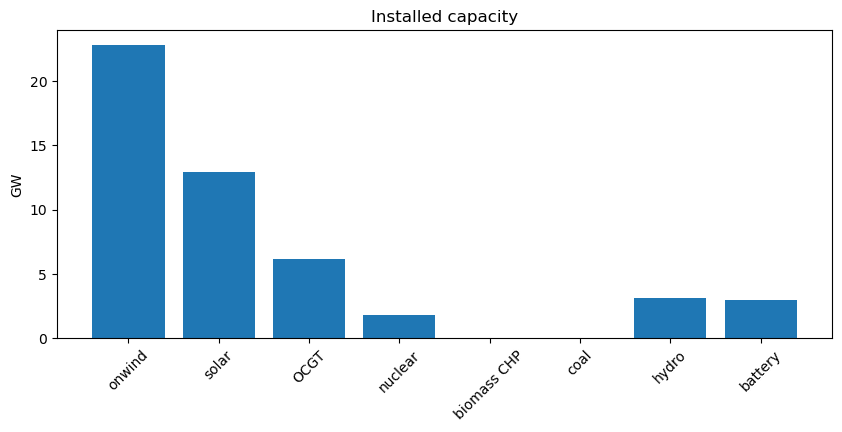

In [ ]:

print(f"CO2 price: {co2_price} €/tCO2")
# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.links.p_nom_opt], axis=0)
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

## F: Connect with neighbours

In [ ]:
### Connect with estonia and sweden ###
network = pypsa.Network()
network.set_snapshots(snapshots.values)
countries = ["FIN", "EST", "SWE"]
coordinates = {
    "FIN": (64, 26),
    "EST": (59, 26),
    "SWE": (62, 15),
}

# Add a CO2 limit constraint
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=1E6, #MtCO2
    type="primary_energy",
)

# Add carriers to the network with CO2 emissions and colors
for i, carrier in enumerate(carriers):
    network.add("Carrier", carrier, co2_emissions=costs.at[carrier, "CO2 intensity"], color=colors[i])

# Add the new countries to the network
for country in countries:
    network.add("Bus", f"{country}_el", y = coordinates[country][0], x = coordinates[country][1], carrier = "AC")
    network.add("Bus", f"{country}_storage", carrier="battery storage", y = coordinates[country][0], x = coordinates[country][1])


    CF = pd.DataFrame(1, index=snapshots, columns=carriers)
    CF = CF.assign(onwind=onshore_all.loc[onshore_all.index.year == year, country].values,
                   solar=solar_all.loc[solar_all.index.year == year, country].values, 
                   hydro=hydro_2015.loc[hydro_2015.index.year == year].values )
    

    for carrier in carriers:
        if carrier != "battery storage":
            network.add("Generator", f"{carrier}_{country}", bus=f"{country}_el", p_nom_extendable=True,
                        p_max_pu=CF[carrier].values,
                        marginal_cost=costs.at[carrier, "marginal_cost"],
                        efficiency=costs.at[carrier, "efficiency"],
                        capital_cost=costs.at[carrier, "capital_cost"],
                        carrier=carrier
            )

    # Add electricity load
    network.add("Load", f"el_load_{country}", bus=f"{country}_el", p_set=demand_all.loc[demand.index.year == year, country].values)

    network.add(
    "StorageUnit",
    f"{country}battery storage",
    bus=f"{country}_el",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
    overwrite=True,
    )

# Limit hydro capacity for each country corresponding to the installed capacity in 2015
network.generators.loc["hydro_EST", "p_nom_max"] = 0
network.generators.loc["hydro_FIN", "p_nom_max"] = 3100 # MW
network.generators.loc["hydro_SWE", "p_nom_max"] = 16_301 # MW

# Add interconnectors between countries
network.add("Link", "FIN-EST", bus0 = "FIN_el", bus1 = "EST_el", p_nom = 1e3, efficiency=0.95, p_max_pu=1, p_min_pu=-1, carrier = "AC")
network.add("Link", "FIN-SWE", bus0 = "FIN_el", bus1 = "SWE_el", p_nom = 2.4e3, efficiency=0.95, p_max_pu=1, p_min_pu=-1, carrier = "AC")

In [ ]:
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 10.35it/s]
INFO:linopy.io: Writing time: 7.31s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-fqmddmco.lp
INFO:gurobipy:Reading time = 2.27 seconds
INFO:gurobipy:obj: 692072 rows, 306628 columns, 1441767 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 306628 primals, 692072 duals
Objective: 1.94e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, St

In [ ]:
network.links.p_nom_opt

Link
FIN_battery    1280.626575
EST_battery    3662.363367
SWE_battery    1280.421685
FIN-EST        5000.000000
FIN-SWE        9568.623901
Name: p_nom_opt, dtype: float64

In [ ]:
# import cartopy.crs as ccrs

# fig, ax = plt.subplots(figsize=(10,4))
# network.plot(bus_sizes = 1/5, margin = 1, projection=ccrs.EqualEarth(),
#     color_geomap=True,
#     line_colors=network.lines_t.p0.mean().abs(),)
# plt.show()

In [ ]:
# network.generators.p_nom_opt.plot.bar()

In [ ]:
# gen = network.generators.assign(g=network.generators_t.p.sum()).groupby(["bus", "carrier"]).g.sum()
# gen_unstacked = gen.unstack()
# gen_unstacked.div(1E3).plot.bar()
# plt.ylabel("GWh")
# plt.show()

## G: Add sector coupling

In [ ]:
# Import temperature data
temp_est = pd.read_excel("Estland_temp.xlsx")
temp_est.index = pd.to_datetime(temp_est['Päev'].astype(str) + '-' + 
                                temp_est['Kuu'].astype(str) + '-' + 
                                temp_est['Aasta'].astype(str) + " " +
                                temp_est["Kell (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S')
temp_est = temp_est["Õhutemperatuur °C"]

temp_swe = pd.read_csv("Sverige_temp.csv")
temp_swe.index = pd.to_datetime(temp_swe['Day'].astype(str) + '-' + 
                                temp_swe['Month'].astype(str) + '-' + 
                                temp_swe['Year'].astype(str) + " " +
                                temp_swe["Time [UTC]"].astype(str),
                                format='%d-%m-%Y %H:%M')
temp_swe = temp_swe["Average temperature [°C]"]

temp_fin = pd.read_csv("Finland_temp.csv", sep=";")
temp_fin.index = pd.to_datetime(temp_fin['Datum'].astype(str) + " " +
                                temp_fin["Tid (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S') 
temp_fin = temp_fin["Lufttemperatur"]

temperature_df = pd.concat(
    [temp_est.rename("EST"), temp_fin.rename("FIN"), temp_swe.rename("SWE")], 
    axis=1
)

temperature_df = temperature_df.loc[(temperature_df.index.year >= 2012) & (temperature_df.index.year < 2018)]

In [ ]:
T_sink = 55 # temperature of the heat sink

def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    cop = (6.81 - 0.121 * delta_t + 0.00063 * delta_t**2)
    cop = cop.fillna(method="ffill")
    return cop.values

network.add("Bus", "gas", carrier="OCGT") # Dummy gas bus
network.add("Store", "gas", e_initial=1E9, e_nom=1E9, bus="gas", carrier = "OCGT") 
network.add("Carrier","heat")


for country in countries:
    network.add("Bus", f"{country}_heat", y = coordinates[country][0], x = coordinates[country][1], carrier="heat")
    network.add("Load", f"heat_load_{country}", bus=f"{country}_heat", p_set=heat_all.loc[:,country].values, carrier = "heat")
    
    network.add(
        "Link",
        f"gas boiler_{country}",
        bus0="gas",
        bus1=f"{country}_heat",
        capital_cost=costs.at["gas boiler steam", "capital_cost"],  # €/MW/a
        marginal_cost=costs.at["gas boiler steam", "marginal_cost"],  # €/MWh
        p_nom_extendable=True,
        efficiency=costs.at["gas boiler steam", "efficiency"],
        carrier = "OCGT"
    )

    # Add heat pump
    temp = temperature_df.loc[temperature_df.index.year == year,f"{country}"] # temperature_df.index.year == year,

    network.add(
        "Link",
        f"heat pump_{country}",
        bus0=f"{country}_el",
        bus1=f"{country}_heat",
        efficiency=cop(temp),
        p_nom_extendable=True,
        capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],  # €/MWe/a
        marginal_cost=costs.at["central air-sourced heat pump", "marginal_cost"],  # €/MWh
        carrier = "heat"
    )


    network.add("Link", f"central gas CHP_{country}",
                bus0="gas",
                bus1=f"{country}_el",
                bus2=f"{country}_heat",
                efficiency=costs.loc["central gas CHP", "efficiency"],
                efficiency2=costs.loc["central gas CHP", "efficiency"],
                p_nom_extendable=True,
                marginal_cost=costs.loc["central gas CHP", "marginal_cost"], # €/MWh
                capital_cost=costs.at["central gas CHP", "capital_cost"],  # €/MWe/a
                carrier = "OCGT"
    )

    # Add heat storage
    network.add("StorageUnit", f"{country}_PTES",
                bus=f"{country}_heat",
                carrier="heat",
                capital_cost = 350, # €/MWh
                efficiency_store=0.8,
                standing_loss = 0.0002,
                efficiency_dispatch=1,
                p_nom_extendable=True,
                cyclic_state_of_charge=True,
    )

In [ ]:
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:01<00:00,  7.65it/s]
INFO:linopy.io: Writing time: 10.92s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-830xxke_.lp
INFO:gurobipy:Reading time = 3.07 seconds
INFO:gurobipy:obj: 1095044 rows, 481840 columns, 2309019 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 481840 primals, 1095044 duals
Objective: 2.72e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-

<Axes: ylabel='Link'>

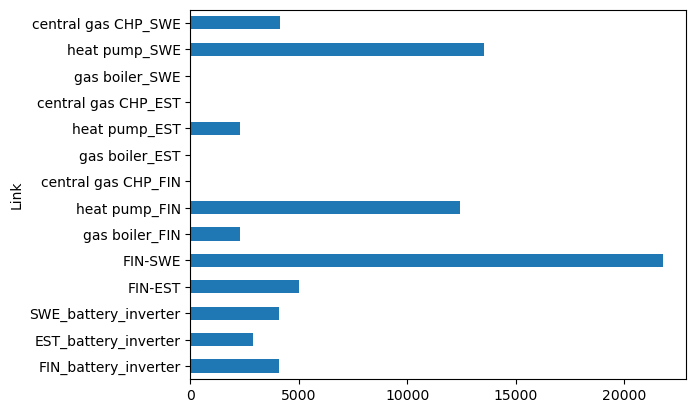

In [ ]:
network.links.p_nom_opt.plot.barh()

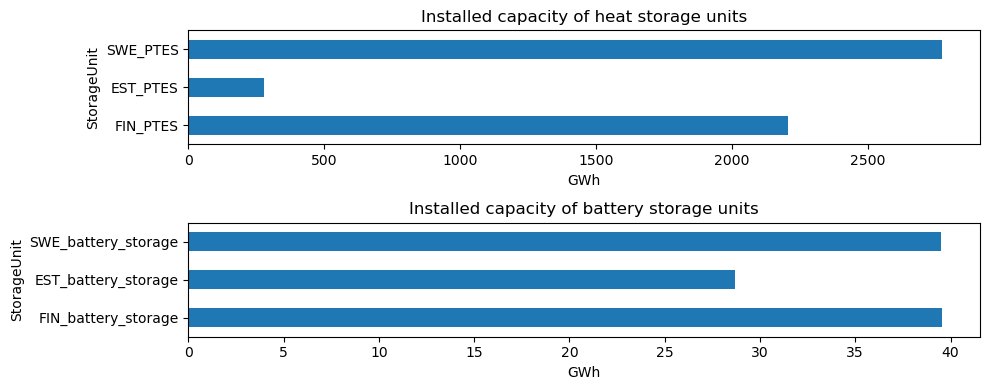

In [ ]:
# Plot the installed capacity of the storage units
fig, ax = plt.subplots(2, 1, figsize=(10,4))
network.storage_units.loc[["FIN_PTES", "EST_PTES", "SWE_PTES"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[0])
ax[0].set_title("Installed capacity of heat storage units")
ax[0].set_xlabel("GWh")

network.storage_units.loc[["FIN_battery_storage", "EST_battery_storage", "SWE_battery_storage"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[1])
ax[1].set_title("Installed capacity of battery storage units")
ax[1].set_xlabel("GWh")

plt.tight_layout()
plt.show()

<Axes: ylabel='Generator'>

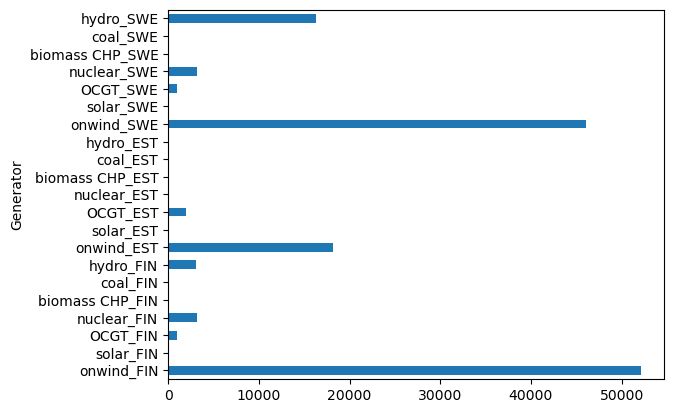

In [ ]:
network.generators.p_nom_opt.plot.barh()

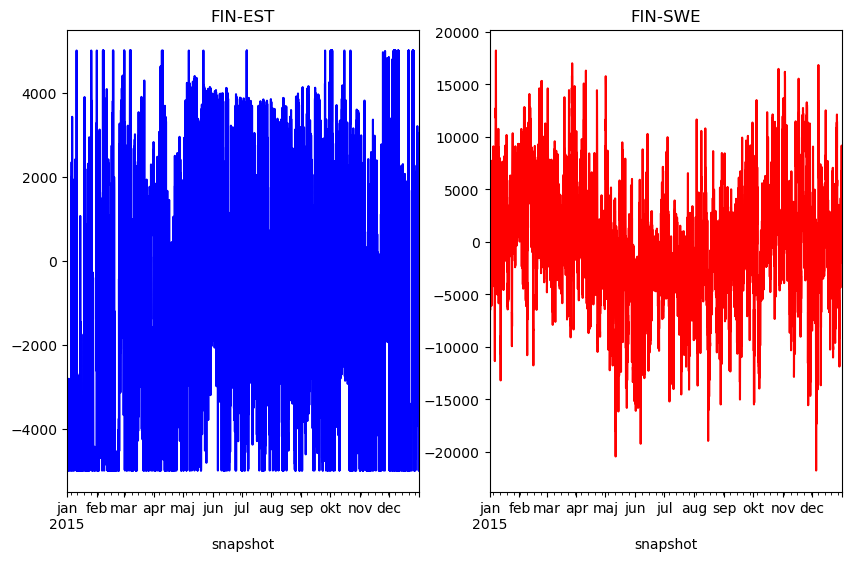

In [ ]:
fix, ax = plt.subplots(1,2, figsize=(10, 6))

# Plot transmission between countries
network.links_t.p0.loc[:,"FIN-EST"].plot(ax=ax[0], color="blue", label="FIN-EST", title="FIN-EST")
network.links_t.p0.loc[:,"FIN-SWE"].plot(ax=ax[1], color="red", label="FIN-SWE", title="FIN-SWE")
plt.show()


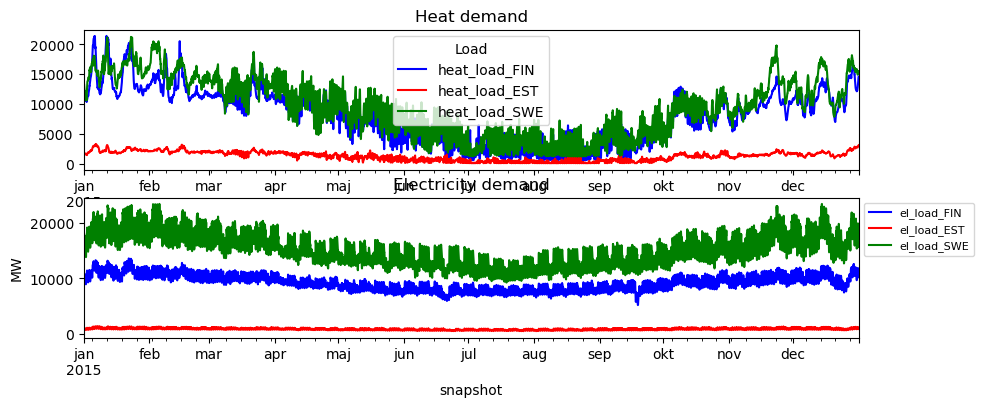

In [ ]:
# print heat and electricity demand
fig, ax = plt.subplots(2, 1, figsize=(10, 4))

network.loads_t.p_set.loc[:,["heat_load_FIN", "heat_load_EST", "heat_load_SWE"]].plot(title="Heat demand", figsize=(10, 4), ax=ax[0], color = ["blue", "red", "green"])
plt.ylabel("MW")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

network.loads_t.p_set.loc[:,["el_load_FIN", "el_load_EST", "el_load_SWE"]].plot(title="Electricity demand", figsize=(10, 4), ax=ax[1], color = ["blue", "red", "green"])
plt.ylabel("MW")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

plt.show()

## H: Explore new topic

In [ ]:
# Impose a cap on onshore wind 
network.generators.loc["onwind_FIN", "p_nom_max"] = 21e3 # MW
network.generators.loc["onwind_EST", "p_nom_max"] = 2.3e3 # MW
network.generators.loc["onwind_SWE", "p_nom_max"] = 30e3 # MW

# Optimize
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:01<00:00,  7.19it/s]
INFO:linopy.io: Writing time: 11.94s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-4n6q2zlx.lp
INFO:gurobipy:Reading time = 3.34 seconds
INFO:gurobipy:obj: 1095046 rows, 481839 columns, 2291501 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 481839 primals, 1095046 duals
Objective: 3.04e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-

<Axes: ylabel='Generator'>

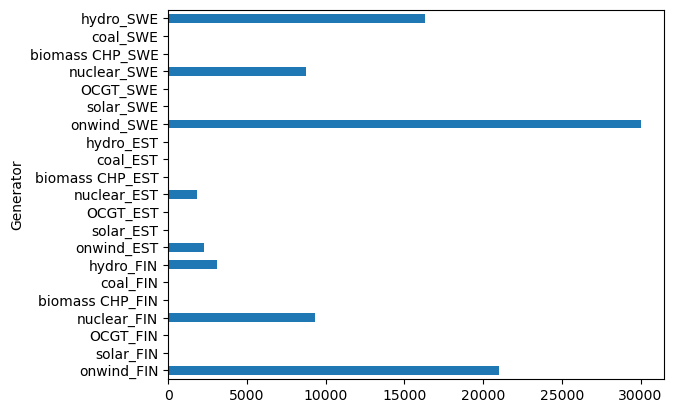

In [ ]:
network.generators.p_nom_opt.plot.barh()

<Axes: ylabel='Link'>

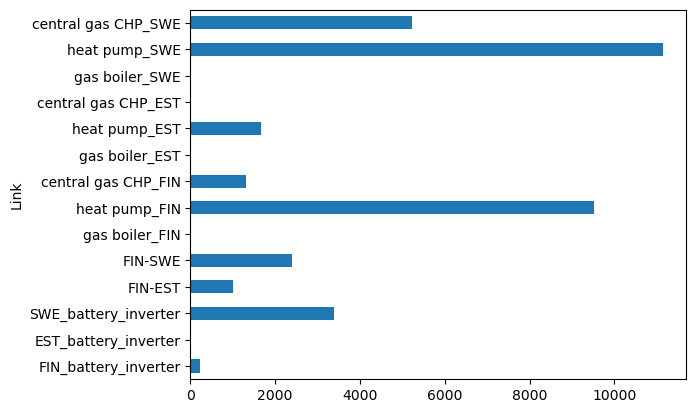

In [ ]:
network.links.p_nom_opt.plot.barh()

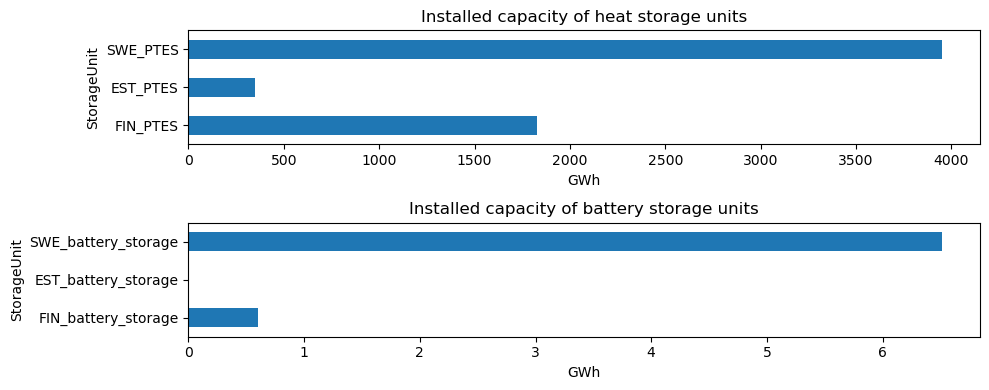

In [ ]:
# Plot the installed capacity of the storage units
fig, ax = plt.subplots(2, 1, figsize=(10,4))
network.storage_units.loc[["FIN_PTES", "EST_PTES", "SWE_PTES"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[0])
ax[0].set_title("Installed capacity of heat storage units")
ax[0].set_xlabel("GWh")

network.storage_units.loc[["FIN_battery_storage", "EST_battery_storage", "SWE_battery_storage"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[1])
ax[1].set_title("Installed capacity of battery storage units")
ax[1].set_xlabel("GWh")

plt.tight_layout()
plt.show()